# gwexpy 時刻操作チュートリアル

このノートブックでは、`gwexpy` で拡張された時刻関連の機能について紹介します。主な改善点は以下の通りです：

1. **ベクトル化された時刻変換**: 大量の時刻データを高速に GPS 時刻へ変換できます。
2. **相互運用性の向上**: Pandas や ObsPy の時刻オブジェクトを直接扱えます。
3. **柔軟な `crop` メソッド**: `TimeSeries` などの切り出しに、GPS 秒だけでなく日付文字列や外部オブジェクトが利用可能です。
4. **`as_series` による自動生成**: 単位から適切なシリーズクラスを自動判別して生成します。

## 1. 高速かつ柔軟な時刻変換 (`to_gps`, `tconvert`)

`gwexpy.time` モジュールは `gwpy.time` を拡張しており、リストや Numpy 配列の一括変換をサポートしています。

In [1]:
import numpy as np
import pandas as pd
from gwexpy.time import to_gps, tconvert

# 1. 文字列のリストを一括変換
time_list = ["2025-01-01 00:00:00", "2025-01-01 00:01:00", "2025-01-01 00:02:00"]
gps_arr = to_gps(time_list)
print("GPS array:", gps_arr)

# 2. Pandas オブジェクトのサポート
df_times = pd.date_range("2025-01-01", periods=3, freq="h")
gps_from_pd = to_gps(df_times)
print("GPS from Pandas:", gps_from_pd)

# 3. tconvert を使った相互変換 (数値なら datetime へ、文字列なら GPS へ)
now_gps = tconvert("now")
print(f"Current GPS: {now_gps}")

dt_list = tconvert(gps_arr)
print("Datetime back-conversion:", dt_list[0])

GPS array: [1.41972482e+09 1.41972488e+09 1.41972494e+09]
GPS from Pandas: [1.7356896e+18 1.7356932e+18 1.7356968e+18]
Current GPS: 1450286998
Datetime back-conversion: 2025-01-01 00:00:37


## 2. 柔軟なデータ切り出し (`crop`)

`TimeSeries` などの `crop` メソッドが拡張され、`start` や `end` に直接日付文字列などを指定できるようになりました。

In [2]:
from gwexpy.timeseries import TimeSeries
from gwexpy.time import to_gps

# サンプルデータの作成 (2025-01-01 00:00:00 UTC)
t0 = to_gps("2025-01-01 00:00:00")
data = np.random.randn(3600)
ts = TimeSeries(data, t0=t0, dt=1)

print(f"Original span: {ts.span}")

# GPS 秒の代わりに文字列で切り出し
ts_cropped = ts.crop(start="2025-01-01 00:10:00", end="2025-01-01 00:20:00")

print(f"Cropped span: {ts_cropped.span}")
print(f"Number of samples: {len(ts_cropped)}")

Original span: [1419724818.0 ... 1419728418.0)
Cropped span: [1419725418.0 ... 1419726018.0)
Number of samples: 600


## 3. シリーズオブジェクトの自動生成 (`as_series`)

`as_series` 関数を使うと、データの単位（次元）に基づいて `TimeSeries` か `FrequencySeries` かを自動的に判断して生成します。

Unit 's' -> <class 'gwexpy.timeseries.timeseries.TimeSeries'>
Unit 'Hz' -> <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Quantities -> <class 'gwexpy.timeseries.timeseries.TimeSeries'>, data: [394368.005      394368.00527778 394368.00555556 ...
 394369.00416667 394369.00444444 394369.00472222]


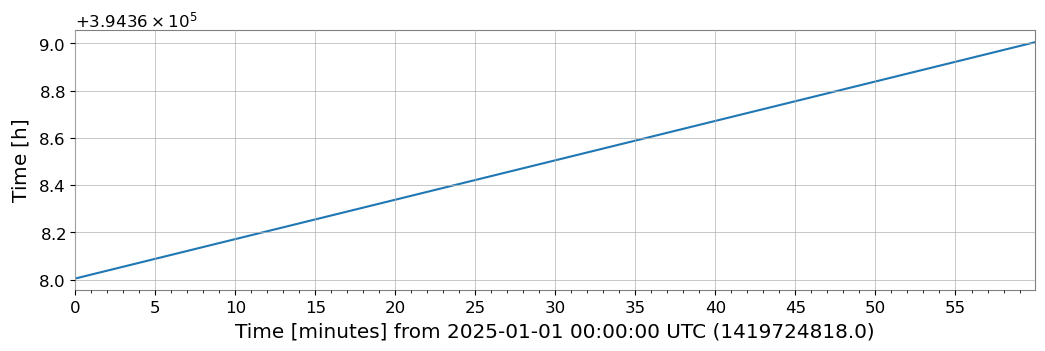

In [3]:
from gwexpy.types import as_series
from astropy import units as u

# 時間単位を指定 -> TimeSeries が生成される
time_data = as_series([1, 2, 3, 4], unit='s', name='MyTimeSeries')
print(f"Unit 's' -> {type(time_data)}")

# 周波数単位を指定 -> FrequencySeries が生成される
freq_data = as_series([10, 20, 30], unit='Hz', name='MySpectrum')
print(f"Unit 'Hz' -> {type(freq_data)}")

# Astropy Quantity からの変換と自動単位変換
q_data = ts.times
ts_from_q = as_series(q_data, unit='h') # s から h へ自動変換して生成
print(f"Quantities -> {type(ts_from_q)}, data: {ts_from_q.value}")
ts_from_q.plot();